In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import os
#print(os.listdir("../input"))

import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#make wider graphs
sns.set(rc={'figure.figsize':(12,5)});
plt.figure(figsize=(12,5));

This notebook is built using some of ideas in the book by *anokas* at  https://www.kaggle.com/anokas/talkingdata-adtracking-eda  .  I suggest reviewing that book first.

For this part I use  the first 10 million rows from train ( as the complete sets are too big for this kernel) and the full test data.

Note:  in the notebook I sometimes refer to downloads as conversions.  i.e. is_attributed == 1  means the click converted.

In [3]:
#import first 10,000,000 rows of train and all test data
train = pd.read_csv('c:\\kaggle\\adtracking\\train.csv', nrows=10000000)
test = pd.read_csv('c:\\kaggle\\adtracking\\test.csv')

In [4]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0


In [5]:
test.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


ip, app, device, os and channel are actually categorical variables encoded as integers.   Set them as categories for analysis.

In [6]:
variables = ['ip', 'app', 'device', 'os', 'channel']
for v in variables:
    train[v] = train[v].astype('category')
    test[v]=test[v].astype('category')

Convert date stamps to date/time type.

In [7]:
#set click_time and attributed_time as timeseries
train['click_time'] = pd.to_datetime(train['click_time'])
train['attributed_time'] = pd.to_datetime(train['attributed_time'])
test['click_time'] = pd.to_datetime(test['click_time'])

#set as_attributed in train as a categorical
train['is_attributed']=train['is_attributed'].astype('category')

Now lets do a quick inspection of train and test data main statistics

In [8]:
train.describe()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
count,10000000.0,10000000.0,10000000.0,10000000.0,10000000.0,10000000,18717,10000000.0
unique,68740.0,332.0,940.0,292.0,170.0,29943,15698,2.0
top,73516.0,12.0,1.0,19.0,245.0,2017-11-06 16:05:10,2017-11-06 23:36:23,0.0
freq,51711.0,1291185.0,9381146.0,2410148.0,793105.0,1261,6,9981283.0
first,NaN,NaN,NaN,NaN,NaN,2017-11-06 14:32:21,2017-11-06 16:00:47,NaN
last,NaN,NaN,NaN,NaN,NaN,2017-11-07 00:12:03,2017-11-07 15:59:53,NaN


*this graph is adapted from https://www.kaggle.com/anokas/talkingdata-adtracking-eda*:

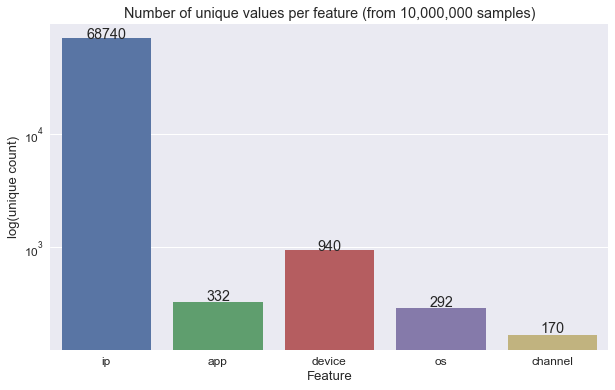

In [9]:
plt.figure(figsize=(10, 6))
cols = ['ip', 'app', 'device', 'os', 'channel']
uniques = [len(train[col].unique()) for col in cols]
sns.set(font_scale=1.2)
ax = sns.barplot(cols, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature (from 10,000,000 samples)')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 
# for col, uniq in zip(cols, uniques):
#     ax.text(col, uniq, uniq, color='black', ha="center")

Quick check to make sure that Nan values in 'attribute_time' are only for samples that did not convert.  Check that counts of 'attributed_time' values is same as count of converted clicks.

In [10]:
#double check that 'attributed_time' is not Null for all values that resulted in download (i.e. is_attributed == 1)
train[['attributed_time', 'is_attributed']][train['is_attributed']==1].describe()

,attributed_time,is_attributed
count,18717,18717.0
unique,15698,1.0
top,2017-11-06 23:36:23,1.0
freq,6,18717.0
first,2017-11-06 16:00:47,NaN
last,2017-11-07 15:59:53,NaN


In [11]:
#set click_id to categorical, for cleaner statistics view
test['click_id']=test['click_id'].astype('category')
test.describe()

,click_id,ip,app,device,os,channel,click_time
count,18790469.0,18790469.0,18790469.0,18790469.0,18790469.0,18790469.0,18790469
unique,18790469.0,93936.0,417.0,1985.0,395.0,178.0,21603
top,18790468.0,5348.0,9.0,1.0,19.0,107.0,2017-11-10 09:00:10
freq,1.0,182522.0,2872176.0,17360269.0,4334532.0,1214650.0,1466
first,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-10 04:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-10 15:00:00


**Quick Notes/Observations** :
- There are only 18717 attributed_time values.  This means only 18,717 out of 10,000,000 clicks resulted in a download.  That's less than 0.2% !
- There are ip adresses that trigger  a click over 50 thousand times.  Seems strange that one ip address would click that often in a span of just 4 days.  Does that mean that ip address encoded is not device id, but network id?  (explore this below)
- First click in train set is on 2017-11-06 14:32:21.  Test clicks start on  2017-11-10.  Based on data specifications, train coveres a 4 day period.  This means that the train and test data do not overlap, but test data is taken the day after train data ends.
-Train data is ordered by timestamp.  (therefore batches pulled in order cover limited time span)
- 2017-11-06 was a Monday.   2017-11-10 was a Friday.  i.e. Train is Mon-Thur, Test is Friday
-There is no missing data in Test.  Missing values in train appear to be only for attributed_time, where there isn't any value due to no app download.

Only a small proportion of clicks were followed by a download:

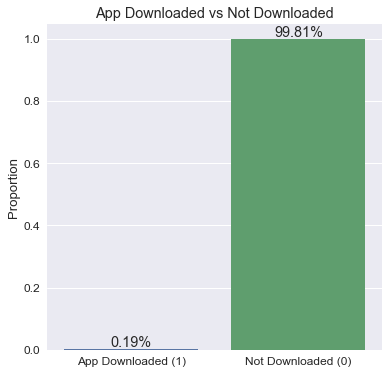

In [12]:
plt.figure(figsize=(6,6))
#sns.set(font_scale=1.2)
mean = (train.is_attributed.values == 1).mean()
ax = sns.barplot(['App Downloaded (1)', 'Not Downloaded (0)'], [mean, 1-mean])
ax.set(ylabel='Proportion', title='App Downloaded vs Not Downloaded')
for p, uniq in zip(ax.patches, [mean, 1-mean]):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.01,
            '{}%'.format(round(uniq * 100, 2)),
            ha="center")

### Explore ip counts.  Check if multiple ips have any downloads.

At this point I was trying to figure out what 'ip' were actually encoding.  My original understanding that ips were user specific did not hold up to scrutiny.
If ip repeated too many times, was it a bot?  This does not appear to be true, as repeated ips do convert.  See below:

In [13]:
#temporary table to see ips with their associated count frequencies
temp = train['ip'].value_counts().reset_index(name='counts')
temp.columns = ['ip', 'counts']
temp[:10]

,ip,counts
0,73516,51711
1,73487,51215
2,5314,35073
3,5348,35004
4,53454,25381
5,105560,23289
6,100275,23070
7,114276,22774
8,201182,22719
9,105475,22047


In [14]:
#add temporary counts of ip feature ('counts') to the train table, to see if IPs with high counts have conversions
train= train.merge(temp, on='ip', how='left')

In [15]:
#check top 10 values
train[train['is_attributed']==1].sort_values('counts', ascending=False)[:10]

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,counts
7912764,73516,34,1,19,243,2017-11-06 23:28:13,2017-11-07 01:13:45,1,51711
289189,73516,19,3033,21,213,2017-11-06 16:05:33,2017-11-06 16:05:52,1,51711
3350587,73516,72,1,18,101,2017-11-06 17:46:37,2017-11-07 09:46:44,1,51711
3416495,73516,10,1,25,377,2017-11-06 17:50:33,2017-11-06 18:50:59,1,51711
6331848,73516,29,1,14,213,2017-11-06 22:36:25,2017-11-07 02:10:05,1,51711
7543731,73516,155,1,19,213,2017-11-06 23:18:10,2017-11-07 15:07:40,1,51711
5144374,73516,9,1,37,234,2017-11-06 20:49:25,2017-11-06 20:53:19,1,51711
3651360,73516,107,1,19,171,2017-11-06 18:05:12,2017-11-06 23:44:44,1,51711
6368416,73516,10,1,13,377,2017-11-06 22:38:04,2017-11-06 22:52:43,1,51711
2073360,73516,9,1,13,134,2017-11-06 16:52:12,2017-11-06 16:52:20,1,51711


In [16]:
train[train['is_attributed']==1].ip.describe()

count     18717
unique    16112
top       73487
freq         56
Name: ip, dtype: int64

So high frequency ip counts do get conversions.   Up to 56 downloads for one ip.  Each IP must be for some network with many devices.

In [17]:
#convert 'is_attributed' back to numeric for proportion calculations
train['is_attributed']=train['is_attributed'].astype(int)

### Conversion rates over Counts of 300 most popular IPs

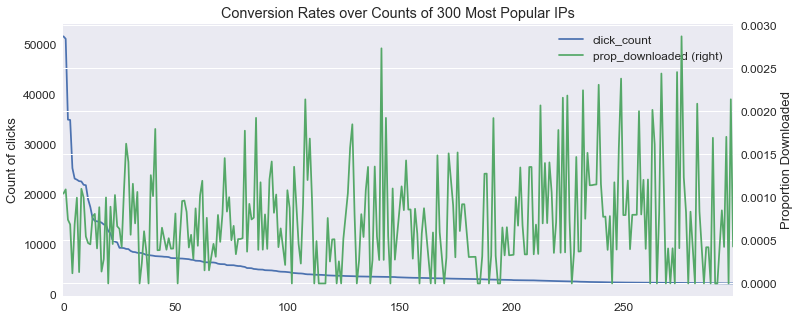

Counversion Rates over Counts of Most Popular IPs
        ip  click_count  prop_downloaded
0    73516        51711         0.001044
1    73487        51215         0.001093
2     5314        35073         0.000741
3     5348        35004         0.000686
4    53454        25381         0.000118
5   105560        23289         0.000687
6   100275        23070         0.000997
7   114276        22774         0.000132
8   201182        22719         0.001100
9   105475        22047         0.000998
10   95766        21966         0.000546
11   26995        19166         0.000470
12  209663        17605         0.000454
13   43793        15398         0.000779
14  137052        14840         0.000809
15   86767        14742         0.000407
16   17149        14673         0.000886
17  111025        14493         0.000138
18  138561        14119         0.000283
19  147957        14012         0.000999


In [18]:
proportion = train[['ip', 'is_attributed']].groupby('ip', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['ip', 'is_attributed']].groupby('ip', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='ip', how='left')
merge.columns = ['ip', 'click_count', 'prop_downloaded']

ax = merge[:300].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 300 Most Popular IPs')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular IPs')
print(merge[:20])


Conversions are noisy and do not appear to correlate with how popular an IP is.

### Conversions by App

Check 100 most popular apps by click count:

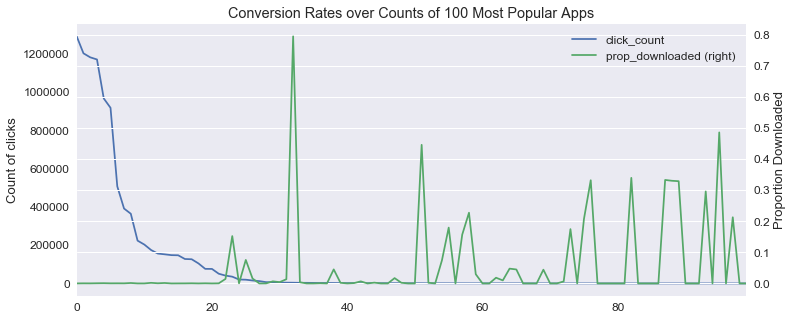

Counversion Rates over Counts of Most Popular Apps
   app  click_count  prop_downloaded
0   12      1291185         0.000140
1    2      1202534         0.000388
2   15      1181585         0.000277
3    3      1170412         0.000630
4    9       966839         0.000869
5   18       917820         0.000397
6   14       507491         0.000483
7    1       391508         0.000350
8    8       364361         0.001441
9   21       223823         0.000089
10  13       203332         0.000103
11  20       174792         0.001962
12  24       156247         0.000550
13  11       152367         0.001503
14  23       148119         0.000027
15   6       147356         0.000176
16  64       127923         0.000258
17  26       126630         0.000537
18  25       104855         0.000095
19  27        76417         0.000523


In [19]:
proportion = train[['app', 'is_attributed']].groupby('app', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['app', 'is_attributed']].groupby('app', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='app', how='left')
merge.columns = ['app', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Apps')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular Apps')
print(merge[:20])

There is a again a huge difference in clicks per app, with minimum of one click on an app and max at almost 13 million.  The proportion flucuates more as the counts go down, since each additional click has larger impact on the proportion value.  In general, for apps with counts in the thousands the ratio stays within 0.0001 - 0.0015 boundary.  For less popular apps it fluxuates more widely.  

### Conversions by OS
Look at top 100 operating systems by click count

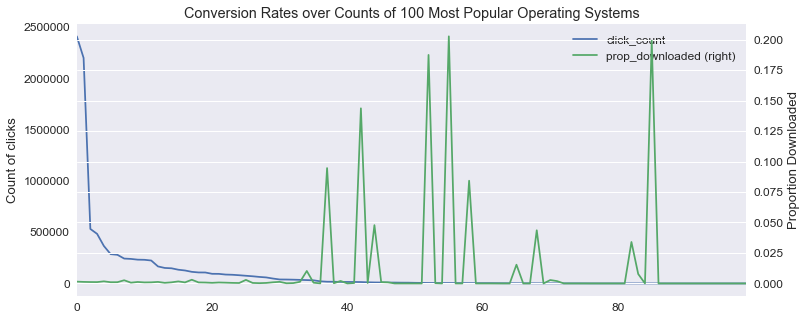

Counversion Rates over Counts of Most Popular Operating Systems
     os  click_count  prop_downloaded
0    19      2410148         0.001489
1    13      2199778         0.001271
2    17       531695         0.001155
3    18       483602         0.001115
4    22       365576         0.001729
5    10       285907         0.001011
6     8       279549         0.001037
7     6       242799         0.002619
8     9       239377         0.000656
9    25       232143         0.001206
10   15       230832         0.000853
11   20       223820         0.000920
12   16       166165         0.001258
13   37       151274         0.000509
14    3       147970         0.000919
15   14       134127         0.001663
16   41       126565         0.000877
17    1       113395         0.003042
18  607       107442         0.000856
19   12       107005         0.000757


In [20]:
proportion = train[['os', 'is_attributed']].groupby('os', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['os', 'is_attributed']].groupby('os', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='os', how='left')
merge.columns = ['os', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Operating Systems')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular Operating Systems')
print(merge[:20])

Same story. For values in the thousands the boundary on the ratio is very low, roughly between 0.0006 and 0.003, but as counts on OS become lower, the ratio starts fluxuating more wildely.

### Conversions by Device

Devices are extremely disproportionately distributed, with number one device used almost 94% of time.  For that device proportion download was 0.001326. (0.13%)

In [21]:
proportion = train[['device', 'is_attributed']].groupby('device', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['device', 'is_attributed']].groupby('device', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='device', how='left')
merge.columns = ['device', 'click_count', 'prop_downloaded']

print('Count of clicks and proportion of downloads by device:')
print(merge)

Count of clicks and proportion of downloads by device:
    device  click_count  prop_downloaded
0        1      9381146         0.001326
1        2       456617         0.000208
2     3032       104393         0.000000
3        0        46476         0.091961
4       59         1618         0.001236
5       40          462         0.246753
6        6          458         0.222707
7       16          334         0.242515
8       18          247         0.226721
9       33          204         0.196078
10      21          190         0.242105
11    3033          151         0.178808
12     154          151         0.178808
13      37          145         0.193103
14      30          126         0.301587
15      46          123         0.211382
16     114          122         0.172131
17       7          121         0.231405
18      88          117         0.324786
19     109          113         0.300885
20      67          111         0.297297
21     748          103         0.000000
22

### Conversions by Channel


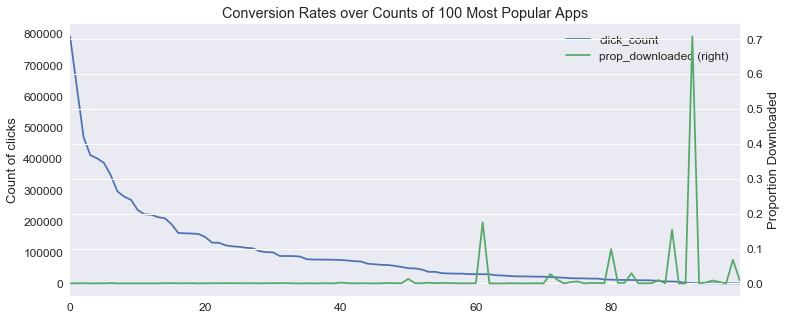

Counversion Rates over Counts of Most Popular Channels
   channel  click_count  prop_downloaded
0      245       793105         0.000105
1      134       630888         0.000558
2      259       469845         0.000653
3      477       412559         0.000073
4      121       402226         0.000323
5      107       388035         0.000379
6      145       348862         0.001155
7      153       296832         0.000182
8      205       279720         0.000232
9      178       269720         0.000119
10     265       236949         0.000236
11     128       223205         0.000130
12     140       222096         0.000347
13     459       214060         0.000187
14     442       210687         0.000646
15     215       191618         0.000778
16     122       163312         0.000582
17     280       162425         0.000345
18     379       161608         0.000811
19     135       160215         0.000200


In [22]:
proportion = train[['channel', 'is_attributed']].groupby('channel', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['channel', 'is_attributed']].groupby('channel', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='channel', how='left')
merge.columns = ['channel', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Apps')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular Channels')
print(merge[:20])

There appear to be a few peaks for channels at reasonable click quantity, but overall the pattern holds same as for categories above.  

# Checking for time patterns

Round the click time down to an hour of the day to see if there are any hourly patterns.

For this part cannot use the first n rows from train data, as it's organized by time.  To get a genral idea for the pattern, will use train data from the randomly sampled 100000 train set provided by organizers.

In [24]:
train_smp = pd.read_csv('c:\\kaggle\\adtracking\\train_sample.csv')

In [25]:
train_smp.head(7)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0
5,93663,3,1,17,115,2017-11-09 01:22:13,NaN,0
6,17059,1,1,17,135,2017-11-09 01:17:58,NaN,0


In [26]:
#convert click_time and attributed_time to time series
train_smp['click_time'] = pd.to_datetime(train_smp['click_time'])
train_smp['attributed_time'] = pd.to_datetime(train_smp['attributed_time'])

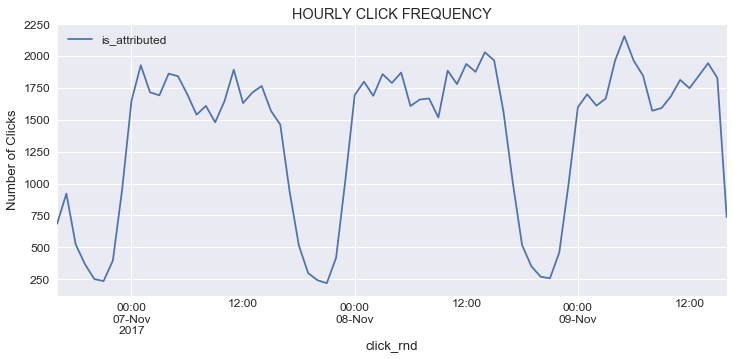

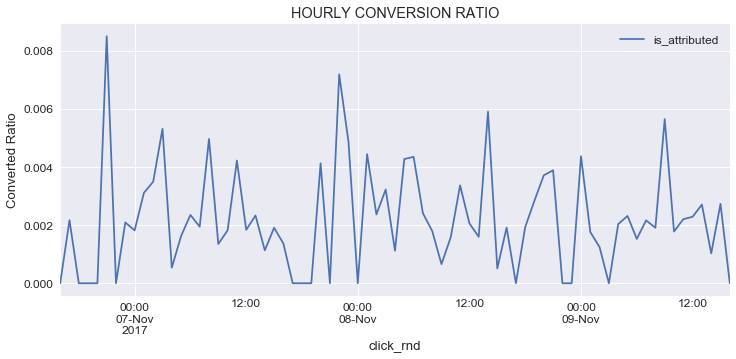

In [27]:
#round the time to nearest hour
train_smp['click_rnd']=train_smp['click_time'].dt.round('H')  

#check for hourly patterns
train_smp[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index=True).count().plot()
plt.title('HOURLY CLICK FREQUENCY');
plt.ylabel('Number of Clicks');

train_smp[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index=True).mean().plot()
plt.title('HOURLY CONVERSION RATIO');
plt.ylabel('Converted Ratio');

There is no clear hourly time pattern in ratios, however there is a definete pattern in frequency of clicks based on time of day.

Lets extract the hour of day from each day as a separate feature, and see combined trend (merge the 4 days together by hour).

In [28]:
#extract hour as a feature
train_smp['click_hour']=train_smp['click_time'].dt.hour

In [ ]:
train_smp.head(7)

Let's check number of clicks by hour:

In [ ]:
train_smp[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).count().plot(kind='bar', color='#a675a1')
plt.title('HOURLY CLICK FREQUENCY Barplot');
plt.ylabel('Number of Clicks');

train_smp[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).count().plot(color='#a675a1')
plt.title('HOURLY CLICK FREQUENCY Lineplot');
plt.ylabel('Number of Clicks');

And number of conversions by hours:

In [ ]:
train_smp[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).mean().plot(kind='bar', color='#75a1a6')
plt.title('HOURLY CONVERSION RATIO Barplot');
plt.ylabel('Converted Ratio');

train_smp[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).mean().plot( color='#75a1a6')
plt.title('HOURLY CONVERSION RATIO Lineplot');
plt.ylabel('Converted Ratio');

let's overlay the two graphs to see if patterns correlate in any way

In [ ]:
#adapted from https://stackoverflow.com/questions/9103166/multiple-axis-in-matplotlib-with-different-scales
#smonek's answer


group = train_smp[['click_hour','is_attributed']].groupby(['click_hour'], as_index=False).mean()
x = group['click_hour']
ymean = group['is_attributed']
group = train_smp[['click_hour','is_attributed']].groupby(['click_hour'], as_index=False).count()
ycount = group['is_attributed']


fig = plt.figure()
host = fig.add_subplot(111)

par1 = host.twinx()

host.set_xlabel("Time")
host.set_ylabel("Proportion Converted")
par1.set_ylabel("Click Count")

#color1 = plt.cm.viridis(0)
#color2 = plt.cm.viridis(0.5)
color1 = '#75a1a6'
color2 = '#a675a1'

p1, = host.plot(x, ymean, color=color1,label="Proportion Converted")
p2, = par1.plot(x, ycount, color=color2, label="Click Count")

lns = [p1, p2]
host.legend(handles=lns, loc='best')

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

plt.savefig("pyplot_multiple_y-axis.png", bbox_inches='tight')

The proportions may be more reliable if estimated on full data.  With the random sample it's  hard too tell because the variability is too high, especially for the hours with low click counts.   i.e. the fewer clicks/conversions, the wider margin of the estimated conversion ratio.  (see below)

In [ ]:
sns.barplot('click_hour', 'is_attributed', data=train_smp)
plt.title('HOURLY CONVERSION RATIO');
plt.ylabel('Converted Ratio');

### Look into attributed_time
It could be useful to learn more about conversions that did take place.
Let's see how much time passed from clicking on the ad to downloading it.

In [ ]:
train_smp['timePass']= train_smp['attributed_time']-train_smp['click_time']
#check:
train_smp[train_smp['is_attributed']==1][:15]

In [ ]:
train_smp['timePass'].describe()

It takes as long as (almost) 20 hours to go from click to purchase and as little as 4 seconds.  

The 4 seconds seems to low to make a decision.  This person would have either seen the ad before, or already been aware of the product some other way.

Does that mean the ad was clicked on multiple times, but only one click was counted as conversion?   Or did the person click on the ad specifically with the intent to download?  (eg, if channel is something like google search, the ad could be clicked during search results view and app downloaded immediately because that's what the person intended to do right away)

Raises questions to explore:
   - How accurately are conversions tracked? How are clicks and downloads linked?  What happens if download after multiple clicks?  Is there a way to identify likely same users (same IP, Device, etc...)

### Check actual train data (the first 10,000,000)
double check the same feature on the first 10 million rows of train data:

In [ ]:
#check first 10,000,000 of actual train data
train['timePass']= train['attributed_time']-train['click_time']
train['timePass'].describe()

Here minimum time from click to download is virtually instanteneous.  How is this possible?  It is clearly not a result of a human decision made from clicking on an ad seen for the first time.